In [1]:
#standard ds imports
import pandas as pd
import numpy as np

#viz and stats
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr

###
# inside acquire.py script:
from env import uname, pwd, host
import env
import os
import wrangle
from sklearn.model_selection import train_test_split
from scipy import stats
import sklearn.preprocessing

#import sklearn mean_square_error

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [2]:
train,validate,test = wrangle.wrangle_zillow()
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1198531 entries, 1941838 to 2079094
Data columns (total 7 columns):
 #   Column         Non-Null Count    Dtype
---  ------         --------------    -----
 0   beds           1198531 non-null  int64
 1   baths          1198531 non-null  int64
 2   sqft           1198531 non-null  int64
 3   taxable_value  1198531 non-null  int64
 4   built          1198531 non-null  int64
 5   tax            1198531 non-null  int64
 6   fips           1198531 non-null  int64
dtypes: int64(7)
memory usage: 73.2 MB


In [3]:
cols = train.drop(columns=['fips','built']).columns.to_list()
train = wrangle.remove_outliers(train,cols)
train.shape

<class 'numpy.float64'>
1.5
<class 'numpy.float64'>
0.5
<class 'numpy.float64'>
-167.0
<class 'numpy.float64'>
-328980.25
<class 'numpy.float64'>
-3266.5


(1069215, 7)

In [4]:
# 2 Compute YHAT of target: taxable_value:

from sklearn.linear_model import LinearRegression

X = train[['sqft']]
y = train['taxable_value']

# assuming X and y are already defined
model = LinearRegression().fit(X, y)
predictions = model.predict(X)
# USE THE THING: make a prediction
# lm.predict will output a numpy array of values,
# we will put those values into a column in df
predictions

array([397580.01756117, 279231.72559134, 416362.82232605, ...,
       238175.50632652, 405226.11507607, 383285.13959852])

In [5]:
train['yhat'] = predictions
train.head()

,beds,baths,sqft,taxable_value,built,tax,fips,yhat
1941838,4,3,2015,209197,1941,2337,6037,397580.017561
1421974,4,2,1303,285279,1960,3029,6111,279231.725591
1346162,3,2,2128,374480,1950,4668,6111,416362.822326
1492536,2,2,1626,243656,1951,3211,6037,332920.627707
349555,3,2,1406,313183,1950,3879,6037,296352.335244


In [6]:
train['baseline'] = train.taxable_value.mean()
train.head()

,beds,baths,sqft,taxable_value,built,tax,fips,yhat,baseline
1941838,4,3,2015,209197,1941,2337,6037,397580.017561,342424.686767
1421974,4,2,1303,285279,1960,3029,6111,279231.725591,342424.686767
1346162,3,2,2128,374480,1950,4668,6111,416362.822326,342424.686767
1492536,2,2,1626,243656,1951,3211,6037,332920.627707,342424.686767
349555,3,2,1406,313183,1950,3879,6037,296352.335244,342424.686767


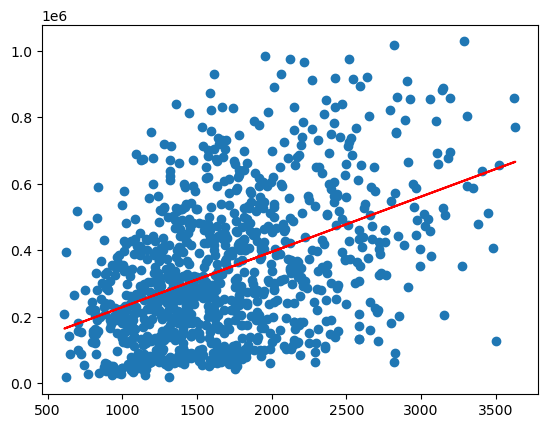

In [7]:
train_1000 = train.sample(1000)
# visualize the line of best fit from OLS linear model

# The scatterplot consists of the **actual taxable_value**
plt.scatter(train_1000.sqft,train_1000.taxable_value)
# The lineplot is my regression line used for predictions
plt.plot(train_1000.sqft,train_1000.yhat,c='red')



In [8]:
# 3 plotting residuals
# residual = actual - predicted

train['baseline_residual'] = train.taxable_value - train.baseline
train['residual'] = train.taxable_value - train.yhat

In [ ]:
# train_1000 = train.sample(1000)

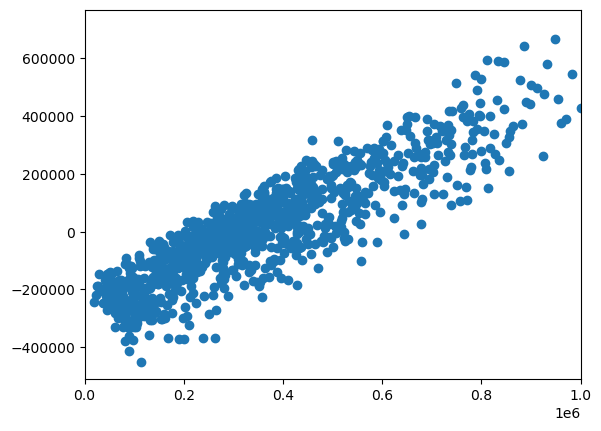

In [10]:
train_1000 = train.sample(1000)
# visualize the line of best fit from OLS linear model

# The scatterplot consists of the **actual taxable_value**
plt.scatter(train_1000.taxable_value,train_1000.residual)
plt.xlim(0,1000000)
plt.show()



In [11]:
train.head()

,beds,baths,sqft,taxable_value,built,tax,fips,yhat,baseline,baseline_residual,residual
1941838,4,3,2015,209197,1941,2337,6037,397580.017561,342424.686767,-133227.686767,-188383.017561
1421974,4,2,1303,285279,1960,3029,6111,279231.725591,342424.686767,-57145.686767,6047.274409
1346162,3,2,2128,374480,1950,4668,6111,416362.822326,342424.686767,32055.313233,-41882.822326
1492536,2,2,1626,243656,1951,3211,6037,332920.627707,342424.686767,-98768.686767,-89264.627707
349555,3,2,1406,313183,1950,3879,6037,296352.335244,342424.686767,-29241.686767,16830.664756


In [12]:
train['baseline_residual_2'] = train.baseline_residual **2
train['residual_2'] = train.residual ** 2

In [13]:
# 4 Calculate SSE SSR SST MSE and RMSE for the MODEL:

# SSE 
# the difference between yhat and y, just squared

SSE_baseline = SST = train.baseline_residual_2.sum()
SSE = train.residual_2.sum()
SSE

3.94330586929903e+16

In [14]:
# SSR = SST - SSE
SSR = SSE_baseline - SSE
SSR

1.0449159439839984e+16

In [15]:
# SST = SSE + SSR or just the SSE_baseline
SSE_baseline

4.988221813283029e+16

In [16]:
# MSE
MSE2 = mean_squared_error(train.taxable_value,train.yhat)
MSE2

36880382984.70402

In [17]:
# RMSE = MSE2 ** 0.5
RMSE = mean_squared_error(train.taxable_value,train.yhat,squared=False)
RMSE

192042.65928356652

In [18]:
# 5 Calculate SSE MSE and RMSE for the BASELINE:

# SSE 
# the difference between yhat and y, just squared

SSE_baseline = train.baseline_residual_2.sum()

SSE_baseline

4.988221813283029e+16

In [19]:
# MSE
MSE2_baseline = mean_squared_error(train.taxable_value,train.baseline)
MSE2

36880382984.70402

In [20]:
# RMSE = MSE2 ** 0.5 for BASELINE
RMSE_baseline = mean_squared_error(train.taxable_value,train.baseline,squared=False)
RMSE_baseline

215993.3384958764

In [21]:
# 6 SSE vs SSE_baseline

SSE_baseline = train.baseline_residual_2.sum()
SSE = train.residual_2.sum()

if SSE < SSE_baseline:
    print(f'With an SSE of {SSE}, our model improves upon Baseline by {round(SSE_baseline - SSE)}')
else:
    print(f'With an SSE of {SSE}, our model DOES NOT improve upon Baseline prediction')

With an SSE of 3.94330586929903e+16, our model improves upon Baseline by 10449159439839984


In [22]:
# 7 What is SSR the amount explained by the regression? the number is output above in # 6
# SSR = SST - SSE
SSR = SSE_baseline - SSE
# the amount of variance (R2) explained by the model is:
SSR / SSE_baseline #manual method SSE_baseline is SST/TSS


0.2094766397920626

In [23]:
# USING sklearn
r2_score(train.taxable_value,train.yhat)

0.20947663979206266

In [ ]:
# 8 Yes, better by approx 21% ie, the model explains 21% of the variance

In [ ]:
# 9 complete